In [1]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
import pycountry
from shapely import wkt
import fiona

# Visualization 
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Machine learning 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the Parquet file
df_encoded = pd.read_parquet('df_encoded.parquet')

# Display the DataFrame
df_encoded

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,region_Caucasus & Central Asia,region_East Asia,region_Eastern Europe,region_Latin America & the Caribbean,region_Middle East & North Africa,region_North America,region_Oceania,region_South Asia,region_Sub-Saharan Africa,region_Western Europe
0,2020,Albania,Eastern Europe,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,0,0,1,0,0,0,0,0,0,0
1,2020,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.0,10.000000,0.0,10.000000,...,0,0,0,0,1,0,0,0,0,0
2,2020,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.5,9.736578,5.0,9.971733,...,0,0,0,0,0,0,0,0,1,0
3,2020,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.5,9.925379,2.0,10.000000,...,0,0,0,1,0,0,0,0,0,0
4,2020,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,0,0,0,1,0,0,0,0,0,0
3482,2000,Vietnam,South Asia,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,0,0,0,0,0,0,0,1,0,0
3483,2000,Yemen,Middle East & North Africa,5.0,10.000000,0.0,NaN,8.170079,19.0,7.932996,...,0,0,0,0,1,0,0,0,0,0
3484,2000,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,NaN,10.000000,0.0,9.827262,...,0,0,0,0,0,0,0,0,1,0


### 1) Statistics

In [3]:
# Data frame information (columns, dtypes, mem usage)
df_encoded.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Columns: 247 entries, year to region_Western Europe
dtypes: float64(62), int64(3), object(7), uint8(175)
memory usage: 2.5+ MB


In [4]:
# Summary statistics
df_encoded.describe()

,year,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,pf_ss_disappearances_injuries_data,pf_ss_killings,...,region_Caucasus & Central Asia,region_East Asia,region_Eastern Europe,region_Latin America & the Caribbean,region_Middle East & North Africa,region_North America,region_Oceania,region_South Asia,region_Sub-Saharan Africa,region_Western Europe
count,3486.000000,3436.000000,3486.000000,3486.000000,1984.000000,3486.000000,3486.000000,3486.000000,3486.000000,3423.000000,...,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.00000,3486.000000,3486.000000
mean,2010.000000,8.442957,9.218442,214.990964,6.602193,8.975160,75.381727,9.072712,108.331216,7.352308,...,0.036145,0.036145,0.132530,0.156627,0.114458,0.012048,0.024096,0.10241,0.271084,0.114458
std,6.056169,3.105136,2.380573,2130.057043,2.840456,2.607188,497.217838,2.412915,796.563634,2.570794,...,0.186677,0.186677,0.339115,0.363500,0.318412,0.109117,0.153370,0.30323,0.444583,0.318412
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.177500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,2005.000000,10.000000,10.000000,0.000000,5.000000,9.713830,0.000000,9.762162,0.000000,5.890000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2010.000000,10.000000,10.000000,0.000000,7.500000,10.000000,0.000000,10.000000,0.000000,8.237500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,2015.000000,10.000000,10.000000,0.000000,10.000000,10.000000,3.000000,10.000000,6.000000,9.472500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
max,2020.000000,10.000000,10.000000,69089.000000,10.000000,10.000000,13075.990000,10.000000,21894.000000,9.917500,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


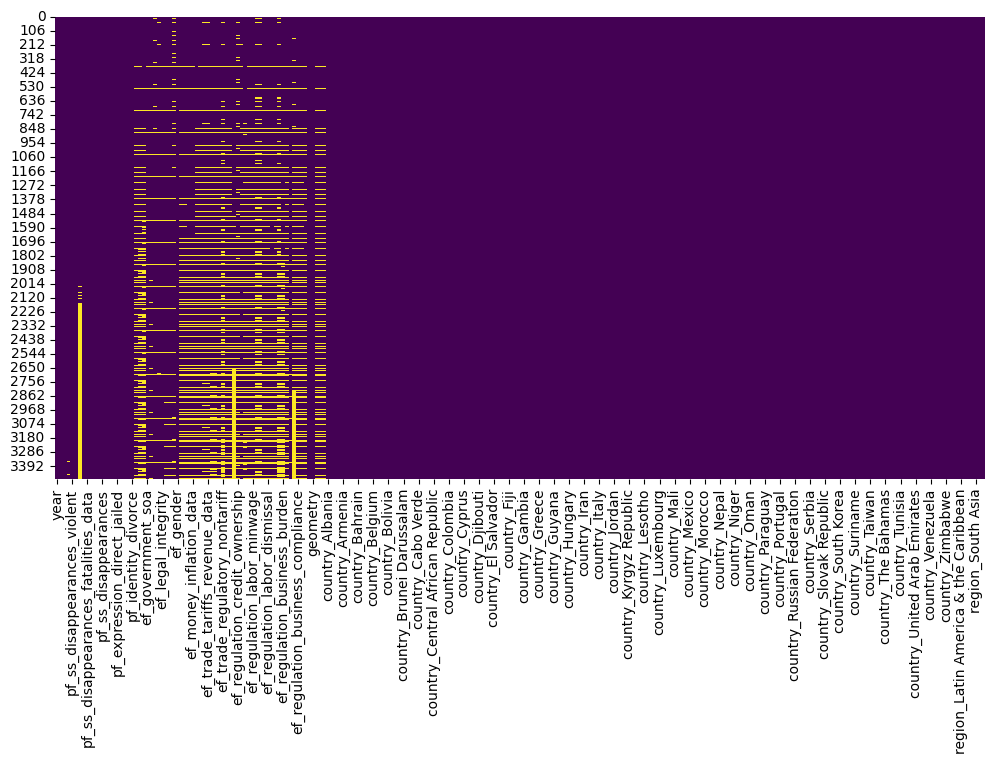

In [5]:
# Assuming you have a DataFrame named df_encoded
missing_data = df_encoded.isnull()

# Plot missing data heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(missing_data, cbar=False, cmap="viridis")
plt.show()

### 2) Visualisations

In [8]:
df_encoded.year.unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010,
       2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000])

In [6]:
#%pip install -U nbformat

Note: you may need to restart the kernel to use updated packages.


In [13]:

# Filter the data frame for the years 2018, 2019, and 2020
filtered_data = df_encoded[df_encoded['year'].isin([2018, 2019, 2020])]

# Aggregate the data by countries, taking the mean of the ef_score
aggregated_data = filtered_data.groupby(['countries'])['ef_score'].mean().reset_index()

# Sort the aggregated data by ef_score in descending order
aggregated_data = aggregated_data.sort_values(by='ef_score', ascending=False)

# Select the top 5 and bottom 5 countries
top_5 = aggregated_data.head(5)
bottom_5 = aggregated_data.tail(5)

# Concatenate the top 5 and bottom 5 countries
selected_data = pd.concat([top_5, bottom_5]).reset_index(drop=True)

# Create a bar chart with two different colors for the top 5 and bottom 5 countries
fig = go.Figure()

fig.add_trace(go.Bar(x=top_5['countries'], y=top_5['ef_score'], text=top_5['ef_score'].round(1), name='Top 5', marker_color='blue'))
fig.add_trace(go.Bar(x=bottom_5['countries'], y=bottom_5['ef_score'], text=bottom_5['ef_score'].round(1), name='Bottom 5', marker_color='red'))

fig.update_traces(textposition='auto')

fig.update_layout(title='Top 5 and Bottom 5 Countries by EF Score (2018-2020)', xaxis_title='Countries', yaxis_title='EF Score')

fig.show()